# Tuning LoRA Hyperparameters - Combinations, 2nd attempt

## Environment Setup

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [6]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-231031-1649'

In [7]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-231031-1649 => Completed
Best parameters found: {'sst2-learning-rate': '0.0021137792486097275'}


{'sst2-learning-rate': 0.0021137792486097275}

In [8]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, TuningJobCompletionCriteriaConfig

In [ ]:

vertical_estimator = PyTorch(**get_default_estimator_parameters())
vertical_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['12_upper', '12_lower', '12_even', 'all'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = vertical_estimator,
    base_tuning_job_name = 'lora-vertical',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}


lora_vertical_tuner = HyperparameterTuner(**tuner_parameters)
lora_vertical_tuner.fit(wait=False)

In [ ]:
lora_vertical_tuner.wait()

In [ ]:
lora_r_estimator = PyTorch(**get_default_estimator_parameters())
lora_r_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', **best_hyperparameters})

n_trials = 8
hpt_ranges = {
    'sst2-lora-r': CategoricalParameter([1, 2, 4, 8, 16, 32]),
    'dummy': CategoricalParameter(list(range(0, n_trials))),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = lora_r_estimator,
    base_tuning_job_name = 'lora-r',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_r_tuner = HyperparameterTuner(**tuner_parameters)
lora_r_tuner.fit(wait=False)

### Horizontal Combinations, 2nd Attempt
To in-/validate our pre-liminary conclusion, let's try again the best combination from the previous "horizontal/by-component" experiment (combining value with ff down projection) and change the combination to now use the weakest attention projection observed, the query projection. So we can check if the best combination from before still produces a significant improvement, or if we hit a lucky run before.

In [6]:
horizontal_comb_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_comb_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 5
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q+ff_u','att_v+ff_d']) 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_comb_estimator,
    base_tuning_job_name = 'lora-horiz-comb2',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horiz_comb_tuner = HyperparameterTuner(**tuner_parameters)
lora_horiz_comb_tuner.fit(wait=False)

Using provided s3_resource


'lora-horiz-comb2-231107-1556'

Tuning job lora-horiz-comb2-231107-1556 status: Completed

Number of training jobs with valid objective: 10
Lowest: 0.9300458431243896 Highest 0.9506880640983582


,dummy,sst2-lora-config,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
5,4,att_q+ff_u,lora-horiz-comb2-231107-1556-005-d22d087e,Completed,2023-11-07 17:08:13+01:00,2023-11-07 17:19:39+01:00,686.0,lora-horiz-comb2-231107-1556,0.950688
3,1,att_v+ff_d,lora-horiz-comb2-231107-1556-007-9ef0e84c,Completed,2023-11-07 16:38:23+01:00,2023-11-07 16:49:02+01:00,639.0,lora-horiz-comb2-231107-1556,0.942661
1,3,att_v+ff_d,lora-horiz-comb2-231107-1556-009-f091a239,Completed,2023-11-07 16:38:41+01:00,2023-11-07 16:47:54+01:00,553.0,lora-horiz-comb2-231107-1556,0.941514
4,0,att_v+ff_d,lora-horiz-comb2-231107-1556-006-c7a52334,Completed,2023-11-07 17:08:13+01:00,2023-11-07 17:19:24+01:00,671.0,lora-horiz-comb2-231107-1556,0.941514
6,3,att_q+ff_u,lora-horiz-comb2-231107-1556-004-cf02be56,Completed,2023-11-07 17:38:30+01:00,2023-11-07 17:48:14+01:00,584.0,lora-horiz-comb2-231107-1556,0.941514
8,1,att_q+ff_u,lora-horiz-comb2-231107-1556-002-3e30d3a9,Completed,2023-11-07 18:48:11+01:00,2023-11-07 18:57:20+01:00,549.0,lora-horiz-comb2-231107-1556,0.941514
0,4,att_v+ff_d,lora-horiz-comb2-231107-1556-010-5d9221ec,Completed,2023-11-07 19:18:58+01:00,2023-11-07 19:28:06+01:00,548.0,lora-horiz-comb2-231107-1556,0.939220
7,2,att_q+ff_u,lora-horiz-comb2-231107-1556-003-544f6b0d,Completed,2023-11-07 18:48:26+01:00,2023-11-07 18:59:05+01:00,639.0,lora-horiz-comb2-231107-1556,0.939220
2,2,att_v+ff_d,lora-horiz-comb2-231107-1556-008-968b37f3,Completed,2023-11-07 17:08:49+01:00,2023-11-07 17:17:56+01:00,547.0,lora-horiz-comb2-231107-1556,0.936927
9,0,att_q+ff_u,lora-horiz-comb2-231107-1556-001-2fa0f5bf,Completed,2023-11-07 16:47:31+01:00,2023-11-07 18:43:33+01:00,6962.0,lora-horiz-comb2-231107-1556,0.930046


Cache Hit/Miss: HHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


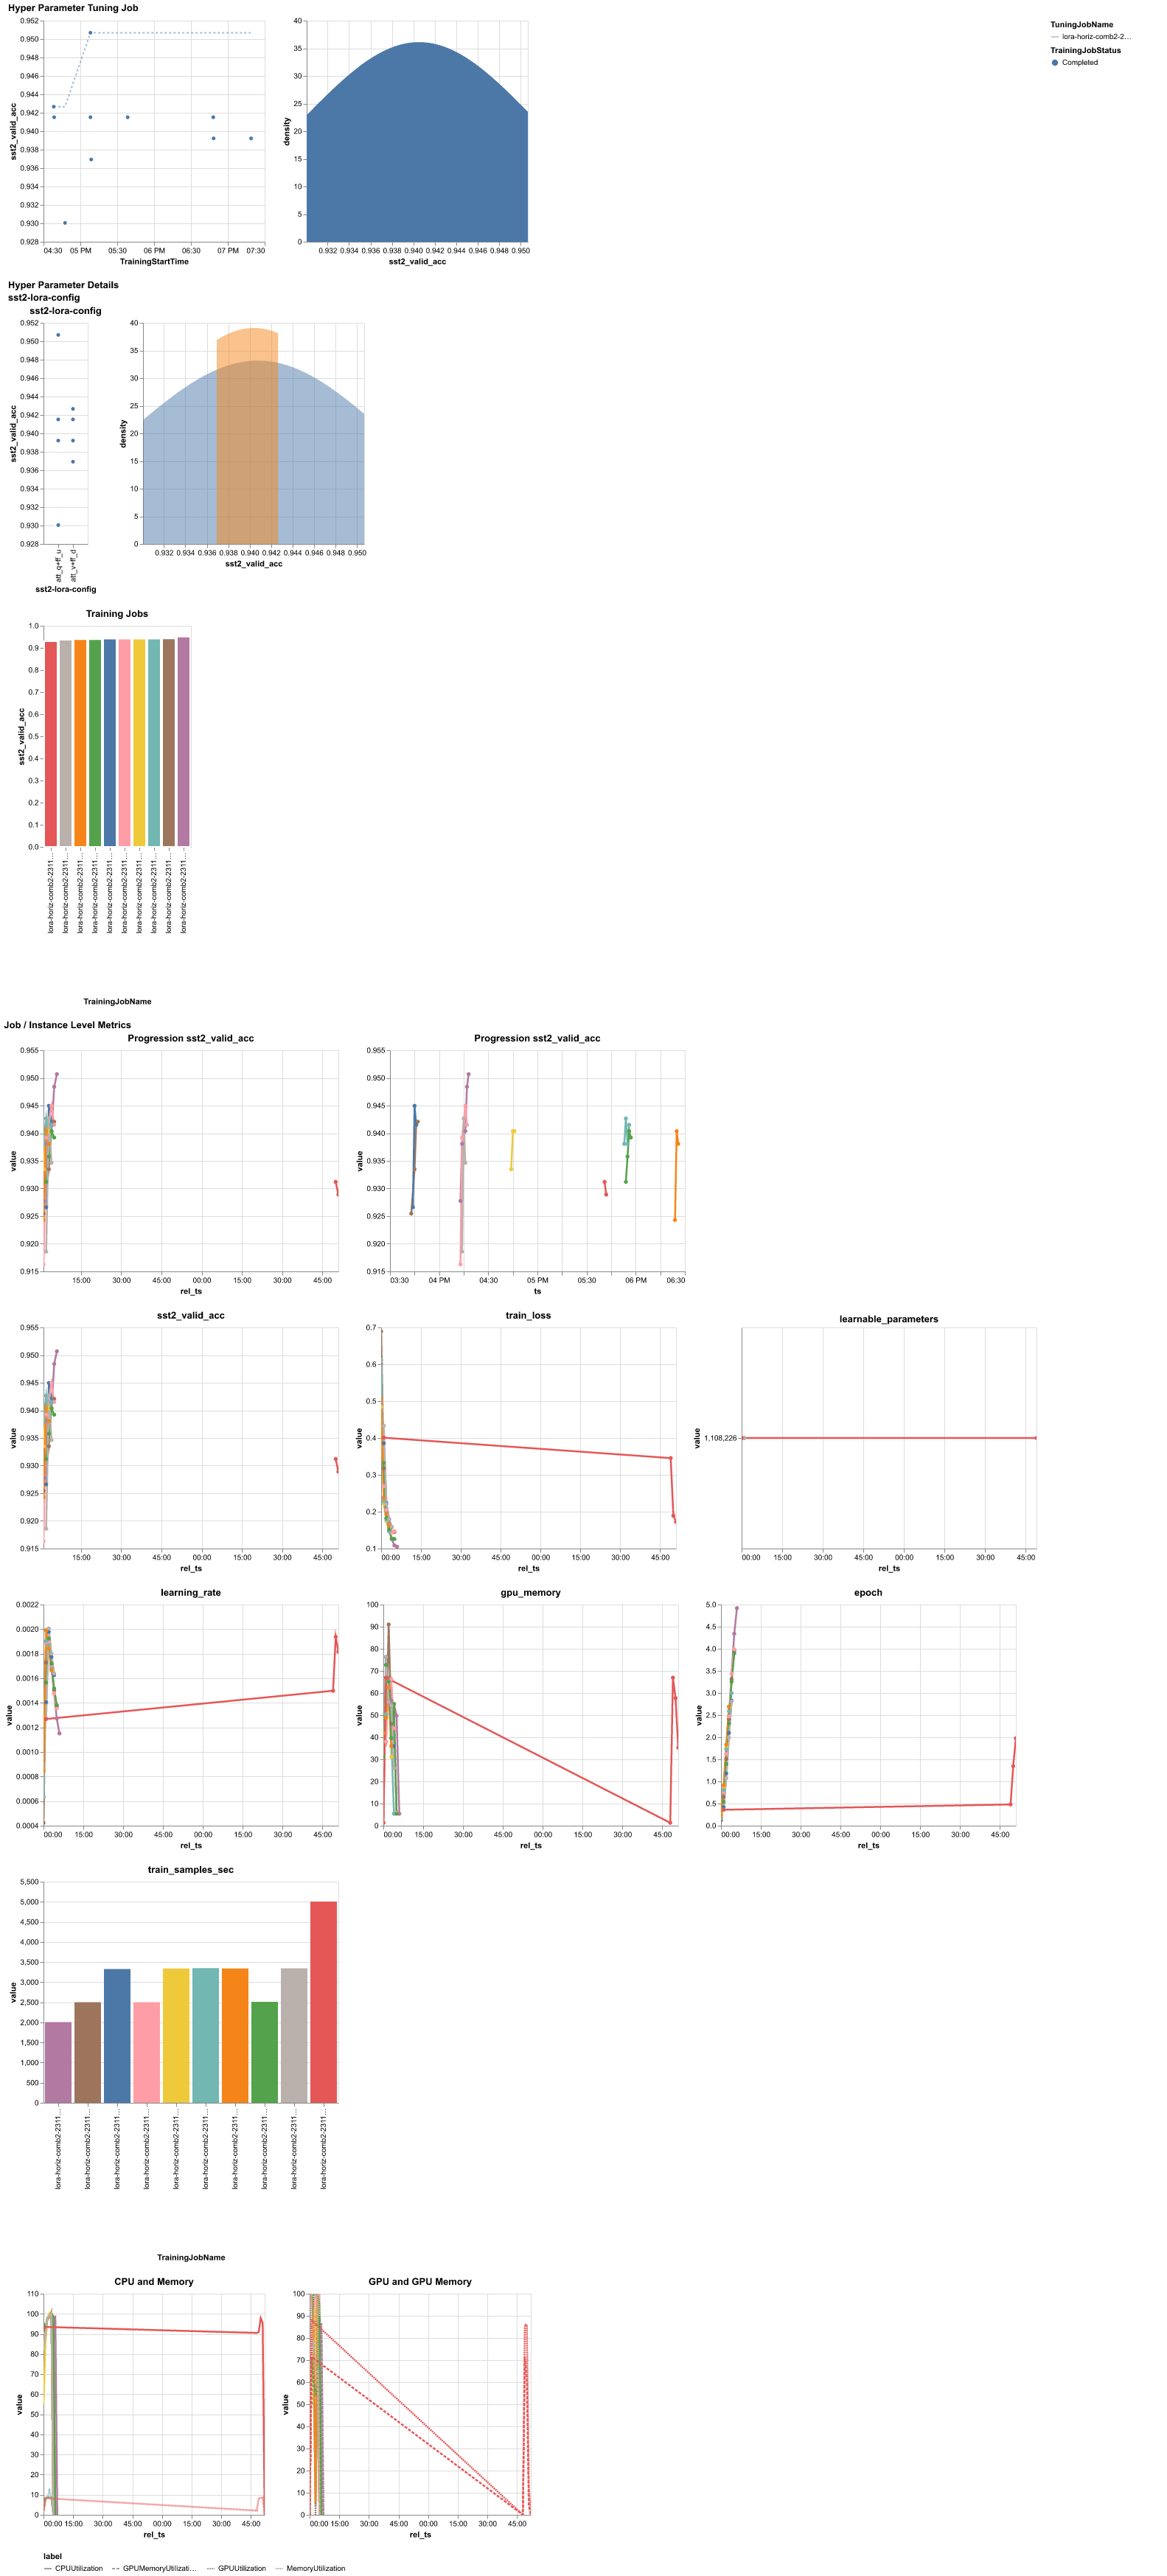

In [9]:
display_tuning_jobs(lora_horiz_comb_tuner)